# Importing the libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import contractions
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import pickle

# !pip install contractions
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alihi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Defined methods

In [2]:
def clean_text(text):
    # \S matches any character that is non-whitespace characters
    text = re.sub(r'http\S+', '', text)
    #remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # encode the text to ascii and ignore the non ascii and convert it to text again
    # remove html tags  => . any char except newline
    text = re.sub(r'<.*>', '', text)
    # remove not a word or space
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_stopwords(text):
    words = word_tokenize(text)
    english_stopwords = set(stopwords.words('english'))
    filtered_words = []
    for word in words:
        if word.lower() not in english_stopwords:
            filtered_words.append(word)
    filtered_text = ' '.join(filtered_words)
    return filtered_text

def spell_check_and_correction(text):
    blob = TextBlob(text)
    corrected_text = str(blob.correct())
    return corrected_text

def to_lower(s):
    return s.lower()

#can't => cannot , I'll => I will
def expanding_contractions(text):
    return contractions.fix(text)

def lemmatization(text):
    text_tokenized = []
    
    words = nltk.word_tokenize(text) #Tokenize

    lemmatizer = WordNetLemmatizer()
    
    for word in words:
        text_tokenized.append(lemmatizer.lemmatize(word)) #lemmatize
    
    text_tokenized = ' '.join(text_tokenized)
    
    return text_tokenized

In [3]:
def preprocess_text(text):
    text = clean_text(text)
#     text = spell_check_and_correction(text)
    text = expanding_contractions(text)
    text = remove_stopwords(text)
    text = to_lower(text)
    text = lemmatization(text)
    return text

# Testing the methods
# print(preprocess_text("print they should pay all the back all the money plus interest the entire family and everyone who came in with them need to be deported asap why didn't it take two years to bust them here we go again another group stealing from the government and taxpayers a group of somalis stole over four million in government benefits over just  months weve reported on numerous cases like this one where the muslim refugeesimmigrants commit fraud by scamming our systemits way out of control more related"))

# Data analysis

In [4]:
df = pd.read_csv("..\..\dataset.csv", encoding = "latin1")
df

,text,label
0,Print They should pay all the back all the mon...,0.0
1,Why Did Attorney General Loretta Lynch Plead T...,0.0
2,Red State : \nFox News Sunday reported this mo...,0.0
3,Email Kayla Mueller was a prisoner and torture...,0.0
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,0.0
...,...,...
156785,"LONDON (Reuters) - LexisNexis, a provider of l...",1.0
156786,MINSK (Reuters) - In the shadow of disused Sov...,1.0
156787,MOSCOW (Reuters) - Vatican Secretary of State ...,1.0
156788,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,1.0


In [5]:
# specify a small information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156790 entries, 0 to 156789
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    153247 non-null  object 
 1   label   151791 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.4+ MB


In [6]:
# display the number of each category with its data type
df["label"].value_counts()

label
0.0    84308
1.0    67483
Name: count, dtype: int64

In [7]:
# display the number of the nan values in each column
df.isna().sum()

text     3543
label    4999
dtype: int64

In [8]:
# display the number of the duplicated rows
df.duplicated().sum()

16621

In [9]:
# display the minimum and maximum number of words in a row of the dataset
word_count = df['text'].str.split().str.len()
print(f"The minimum number of words: {int(word_count.min())}")
print(f"The maximum number of words: {int(word_count.max())}")

The minimum number of words: 0
The maximum number of words: 5965


# Data preprocssing

In [10]:
# remove nan and -inf values
df = df.dropna()
df.isna().sum()

text     0
label    0
dtype: int64

In [11]:
# change the type of the label column to int
df.loc[:, 'label'] = df['label'].astype(int)
df['label'].value_counts()

label
0.0    84232
1.0    67401
Name: count, dtype: int64

In [12]:
# drop the duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [13]:
# shuffle the rows
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df

,text,label
0,MEXICO CITY (Reuters) - Fourteen people were s...,1.0
1,Another successful cleansing of our history ...,0.0
2,HAVANA (Reuters) - Cuba is willing to talk wit...,1.0
3,Celebrity News Will Smith has cut off his son...,0.0
4,Every website has a 404 page that you land on ...,0.0
...,...,...
138665,trump get electric chair cheat debate like hil...,0.0
138666,barack obama delay suspend election hillary fo...,0.0
138667,STRASBOURG/PARIS (Reuters) - President Emmanue...,1.0
138668,WASHINGTON (Reuters) - President Donald TrumpÃ...,1.0


In [14]:
df["text"] = df["text"].apply(preprocess_text)
# df = df.dropna()
df

,text,label
0,mexico city reuters fourteen people shot dead ...,1.0
1,another successful cleansing history like next...,0.0
2,havana reuters cuba willing talk united state ...,1.0
3,celebrity news smith cut son jadens dreadlock ...,0.0
4,every website 404 page land type wrong address...,0.0
...,...,...
138665,trump get electric chair cheat debate like hil...,0.0
138666,barack obama delay suspend election hillary fo...,0.0
138667,strasbourgparis reuters president emmanuel mac...,1.0
138668,washington reuters president donald trump admi...,1.0


In [15]:
# filter the rows with less than 20 words
word_count = df['text'].str.split().str.len()
print(f"Number of words before filtering: minimum={int(word_count.min())}   maximum={int(word_count.max())}")
df = df[df['text'].str.split().str.len().gt(9) & df['text'].str.split().str.len().lt(551)]
word_count = df['text'].str.split().str.len()
print(f"Number of words before filtering: minimum={int(word_count.min())}   maximum={int(word_count.max())}")

Number of words before filtering: minimum=0   maximum=5105
Number of words before filtering: minimum=10   maximum=550


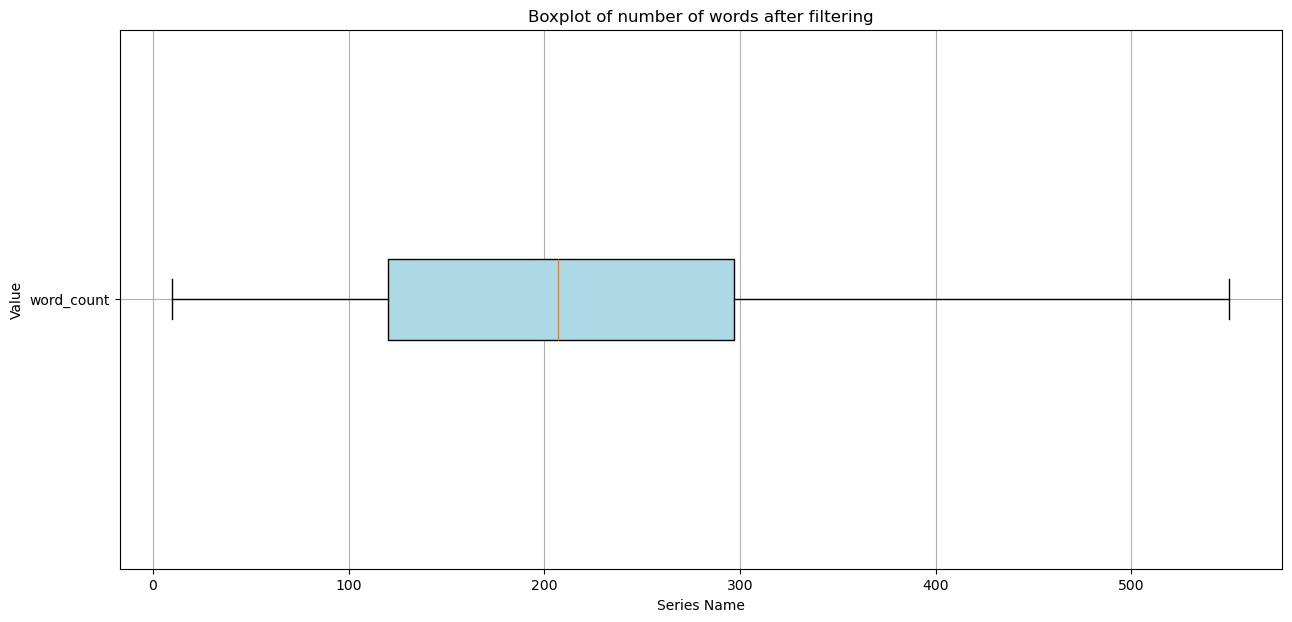

In [16]:
# Check for outliers after filtering
plt.figure(figsize=(15, 7))
plt.boxplot(df['text'].str.split().str.len(), labels=["word_count"], vert=False, patch_artist=True)
plt.xlabel("Series Name")
plt.ylabel("Value")
plt.title("Boxplot of number of words after filtering")
plt.grid(True)
boxes = plt.gca().get_children()[0]
boxes.set_facecolor('lightblue')
plt.show()

In [17]:
df['label'].value_counts()

label
0.0    61251
1.0    57967
Name: count, dtype: int64

In [18]:
num_to_drop = 3284

# Get indices of the first 'num_to_drop' rows with label 0
drop_indices = df[df['label'] == 0].index[:num_to_drop]

# Drop rows based on indices
df = df.drop(drop_indices)
df['label'].value_counts()

label
1.0    57967
0.0    57967
Name: count, dtype: int64

In [19]:
df

,text,label
0,mexico city reuters fourteen people shot dead ...,1.0
2,havana reuters cuba willing talk united state ...,1.0
7,military aircraft crash syria injure two offic...,1.0
9,syria syrian force patrol area awijah advance ...,1.0
11,actor mandy patinkin maybe white men military ...,1.0
...,...,...
138663,happens lung brain mood use himalayan salt lam...,0.0
138664,report copyright violation sense giant earthqu...,0.0
138665,trump get electric chair cheat debate like hil...,0.0
138667,strasbourgparis reuters president emmanuel mac...,1.0


In [20]:
df.to_csv("..\..\df_processed.csv", index=False)

In [21]:
df = pd.read_csv("..\..\df_processed.csv")
# df = df.dropna()
df

,text,label
0,mexico city reuters fourteen people shot dead ...,1.0
1,havana reuters cuba willing talk united state ...,1.0
2,military aircraft crash syria injure two offic...,1.0
3,syria syrian force patrol area awijah advance ...,1.0
4,actor mandy patinkin maybe white men military ...,1.0
...,...,...
115929,happens lung brain mood use himalayan salt lam...,0.0
115930,report copyright violation sense giant earthqu...,0.0
115931,trump get electric chair cheat debate like hil...,0.0
115932,strasbourgparis reuters president emmanuel mac...,1.0


# TF-IDF

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vectorizer = CountVectorizer(ngram_range=(1, 1))
#1 1 unigrams only , 1 2 uniand bigrams ,  3 3 trigrams only
tfidf_transformer = TfidfTransformer(smooth_idf=False)
counts = count_vectorizer.fit_transform(df['text'].values)
#matrix of token counts // sparse matrix 
tfidf = tfidf_transformer.fit_transform(counts)
print(tfidf)

  (0, 282539)	0.0681051269442242
  (0, 278397)	0.06164326617148735
  (0, 277045)	0.09764903970459088
  (0, 275415)	0.03419864854103555
  (0, 271138)	0.052737657409840245
  (0, 271039)	0.044983701879157185
  (0, 265691)	0.029144221771033388
  (0, 263231)	0.05295162702066629
  (0, 261569)	0.03392451755344192
  (0, 257382)	0.08550110063810172
  (0, 251149)	0.10974306260675874
  (0, 241336)	0.04335171158290333
  (0, 238840)	0.08585530781063674
  (0, 237383)	0.08247592957068804
  (0, 237324)	0.10798944902257927
  (0, 234694)	0.05489981625551812
  (0, 234212)	0.08510732854473775
  (0, 232031)	0.05821240779802415
  (0, 232022)	0.10171259049973642
  (0, 230458)	0.048232244664834605
  (0, 230216)	0.05700863430534782
  (0, 220958)	0.11866926498770082
  (0, 220153)	0.10193552873414906
  (0, 218870)	0.1275370113672957
  (0, 218501)	0.10798944902257927
  :	:
  (115933, 33853)	0.03950135525493983
  (115933, 33701)	0.03587018303132377
  (115933, 32386)	0.046784085275570875
  (115933, 31904)	0.0276311

In [23]:
import itertools
dict(itertools.islice(count_vectorizer.vocabulary_.items(), 10)) 

{'mexico': 156315,
 'city': 56519,
 'reuters': 215254,
 'fourteen': 98484,
 'people': 183567,
 'shot': 230458,
 'dead': 70457,
 'tuesday': 261569,
 'night': 168568,
 'drug': 80399}

# Spliting to training set and test set

In [24]:
x_train, x_test, y_train, y_test = train_test_split(tfidf, df['label'], test_size=0.2 , shuffle=False)

In [25]:
def train(model , name):
    model.fit(x_train,y_train)
    print(f"Training accuracy of {name} is {round(model.score(x_train, y_train) * 100, 3)}%")
    print(f"Testing accuracy of {name} is {round(model.score(x_test, y_test) * 100, 3)}%")
    print()
    return round(model.score(x_test, y_test) * 100, 3)
    
def conf_matrix(model):
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
    
def class_report(model):
    print(classification_report(y_test, model.predict(x_test)))

Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
F1 = 2 * (Precision * Recall) / (Precision + Recall)


True Positive (TP)       |        True Negative (TN)
-------               -------
True Negative (FN)        |        False Positive (FP)

# Decision Tree

Training accuracy of Decision Tree is 89.646%
Testing accuracy of Decision Tree is 88.808%

              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90     11836
         1.0       0.95      0.82      0.88     11351

    accuracy                           0.89     23187
   macro avg       0.90      0.89      0.89     23187
weighted avg       0.90      0.89      0.89     23187



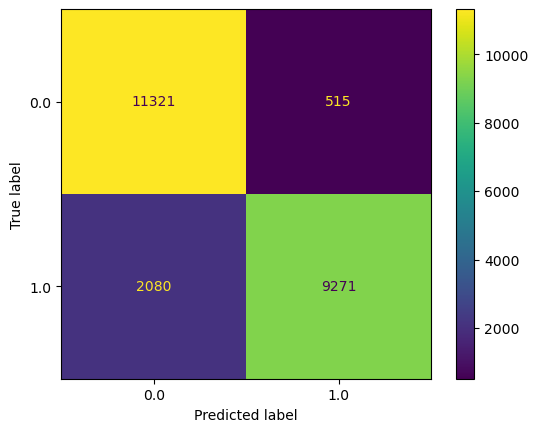

In [26]:
dt = DecisionTreeClassifier(criterion="entropy",max_depth=10,random_state=42)
dt_acc = train(dt, "Decision Tree")
conf_matrix(dt)
class_report(dt)

# Random Forest

Training accuracy of Random Forest is 93.342%
Testing accuracy of Random Forest is 77.957%

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     11836
         1.0       0.78      0.76      0.77     11351

    accuracy                           0.78     23187
   macro avg       0.78      0.78      0.78     23187
weighted avg       0.78      0.78      0.78     23187



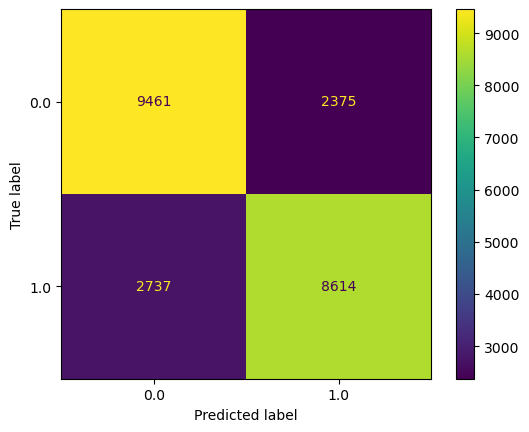

In [27]:
rf = RandomForestClassifier(criterion="entropy", max_depth=100, n_estimators=10, n_jobs=-1, random_state=42)
rf_acc = train(rf, "Random Forest")
conf_matrix(rf)
class_report(rf)

# Choosing the best model

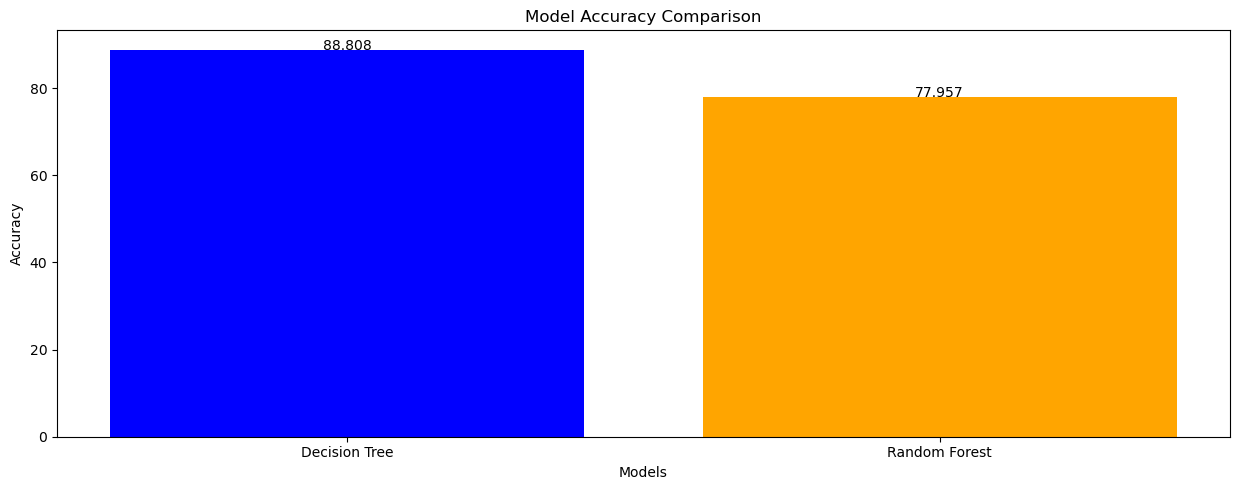

In [28]:
models = ["Decision Tree", "Random Forest"]

accuracies = [dt_acc, rf_acc]

colors = ["blue", "orange"]

plt.figure(figsize=(12.5, 5))
plt.bar(models, accuracies, color=colors)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i in range(len(models)):
        plt.text(i, accuracies[i], accuracies[i], ha = 'center')
plt.tight_layout()
plt.show()

### Clearly Decision Tree has the hightest accuracy so we will save it for deployment

# Save the TF-IDF and model objects

In [29]:
# pickle.dump(count_vectorizer, open('../api/vectorizer.pkl', 'wb'))

In [30]:
# pickle.dump(tfidf_transformer, open('../api/transformer.pkl', 'wb'))

In [31]:
# pickle.dump(dt, open('../api/dt.pkl', 'wb'))

# Load the TF-IDF and model objects

In [32]:
vectorizer = pickle.load(open('../api/vectorizer.pkl', 'rb'))

In [33]:
transformer = pickle.load(open('../api/transformer.pkl', 'rb'))

In [34]:
model = pickle.load(open('../api/dt.pkl', 'rb'))

# Classifing a single news article

In [35]:
def fake_news(article):
    article = preprocess_text(article)
    article = [article]
    article = vectorizer.transform(article)
    article = transformer.transform(article)
    prediction = model.predict(article)
    return prediction[0]

In [36]:
article = """There is a lot more than meets the eye to this mob , wait till you read this . &quot;Soon thereafter I resigned from Yang and took another job at the Florida Department of Transportation (FDOT). While there, I discovered some other illegal activities of Yang, who had contracts with FDOT, involving over-billing and defrauding of the State of Florida regarding contracts Nee was sentenced on October 7, 2004 by U.S. District Judge Gregory A. Presenell to three years of supervised probation and $100 fine. An illegal Chinese alien admitting to what is paramount to corporate if not treasonable espionage, and the guy gets a slap on the wrist. http://www.bradblog.com/?page_id=3526  now finding the connection to Serco via contracts ...."""
ans = fake_news(article)
if(ans == 0):
    print("FALSE NEWS!!!")
else:
    print("TRUE NEWS")

FALSE NEWS!!!


In [ ]:
article = """patrick stewart literally pay guy vote donald trump image patrick stewart despise donald trump much make feel well pay guy vote himthe actor know captain picard star trek next generation xmen film franchise new orleans earlier week spot homeless man hold sign state exchange would vote trumpnot stewart give give four dollar top extra measure make forget humidity moment worth buck stewart write twitter complete image man signmade forget humidity moment worth buck pictwittercomlrveozmf patrick stewart sirpatstew may first time stewart slam donald trump week ago express vice believe anyone take trump antic seriously well course idea dreadful trump would antic call antic could possibly take seriously stewart make remark response ask donald trump extremism support among white supremacist group make late film green room stewart portray neonazi timelyclearly patrick stewart donald trump supporter blame donald trump scary political candidate presidential race fact man strong support white supremacist racist hate group could well end become leader free world nightmare close turn realityfaced kind person office perhaps give five dollar people keep voting trumpfeatured image via wikimedia"""
article = preprocess_text(article)
print(len(article.split()))
article = [article]
counts = count_vectorizer.transform(article)
tfidf = tfidf_transformer.transform(counts)
# print(f"pac: {pac.predict(tfidf)}")
print(f"dt: {dt.predict(tfidf)}")
leaf_node = model.apply(tfidf)
probabilities = model.predict_proba(tfidf)
print()
# print(f"lr: {lr.predict(tfidf)}")
# print(f"sgd: {sgd.predict(tfidf)}")
# print(f"mnb: {mnb.predict(tfidf)}")
# print(f"abc: {abc.predict(tfidf)}")